In [2]:
!pip install numpy
!pip install pandas
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn
!pip install xgboost

Starting Diabetes ML Pipeline

1. Loading data...
Data shape: (768, 9)
Columns: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

3. Preparing features and target...

3. Splitting data...
 Train: (614, 8), Test: (154, 8)

5. Building Preprocessing pipeline...

6. Selecting XGBoost model...

8. Training model...
Fitting 5 folds for each of 18 candidates, totalling 90 fits

Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}

8. Evaluating model...

Test Metrics:
  ACCURACY: 0.7273
  PRECISION: 0.6429
  RECALL: 0.5000
  F1: 0.5625
  ROC_AUC: 0.6750

10. Saving artifacts...

Artifacts saved successfully.

PIPELINE COMPLETED SUCCESSFULLY!



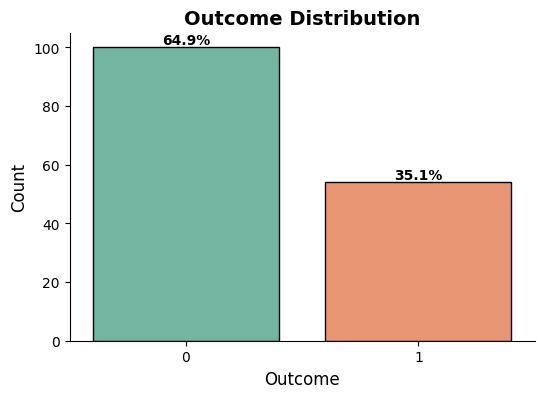

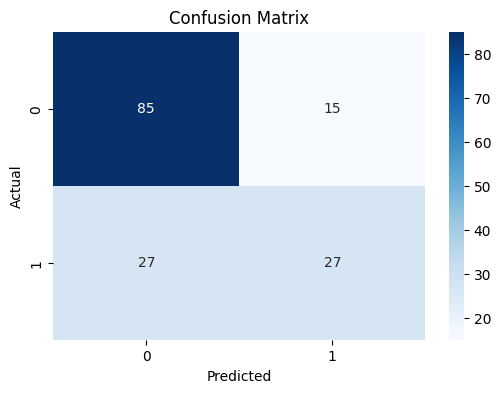

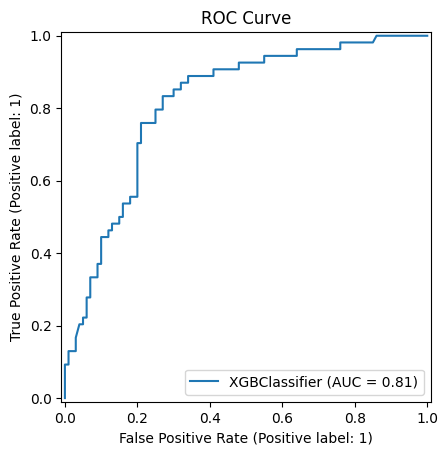

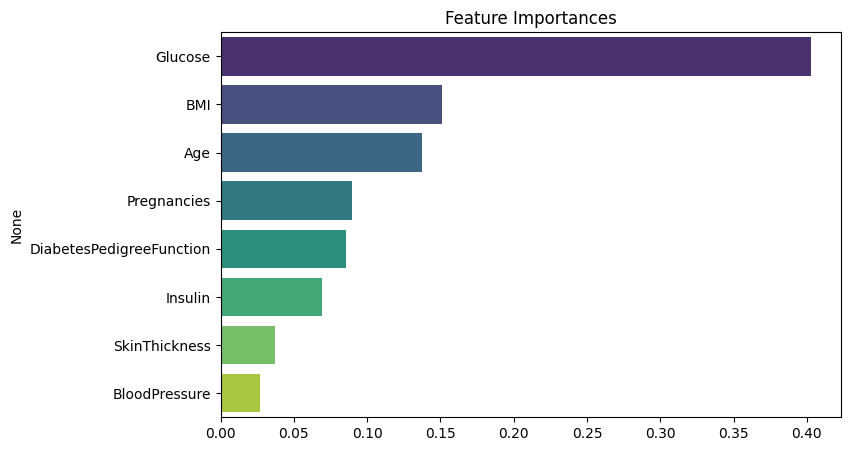

In [12]:
#                         -----------Diabetes Prediction Pipeline-----------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
from pathlib import Path

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
        accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
         confusion_matrix, RocCurveDisplay)

import warnings
warnings.filterwarnings('ignore')

                     # ============= Configuration ==================
class config:

    # Data setting
    DATA_PATH = 'diabetes.csv'
    TARGET_COL = 'Outcome'
    TEST_SIZE = 0.2
    RANDOM_STATE = 42

    # Model Setting
    MODEL_TYPE = 'XGBoost'            # Options: 'RandomForest', 'XGBoost', 'LogisticRegression
    USE_GRID_SEARCH = True

    # Path for saving
    MODEL_SAVE_PATH = "models/best_model.pkl"
    METRICS_SAVE_PATH = "models/metrics.json"
    PREPROCESSOR_SAVE_PATH = "models/preprocessor.pkl"

                     # =============== Main Pipeline ==================

def run_diabetes_pipeline(config):
    
    print('='*60)
    print('Starting Diabetes ML Pipeline')
    print('='*60)

    # 1. Load Data
    print("\n1. Loading data...")
        
    df = pd.read_csv(config.DATA_PATH)
    print(f'Data shape: {df.shape}')
    print(f'Columns: {list(df.columns)}')

    # 2. Handle Zero as missing values
    col_with_invalid_zero = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
    df[col_with_invalid_zero] = df[col_with_invalid_zero].replace(0, np.nan)

    # 3. Features & Target
    print("\n3. Preparing features and target...")

    if config.TARGET_COL not in df.columns:
        raise ValueError(f" Target column '{config.TARGET_COL}' not found!")

    X = df.drop(columns=[config.TARGET_COL])
    y = df[config.TARGET_COL]

    # 4. Train-Test Split
    print("\n3. Splitting data...")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=config.TEST_SIZE, 
                                                        random_state=config.RANDOM_STATE, stratify=y)
    print(f' Train: {X_train.shape}, Test: {X_test.shape}')

    # 5. Preprocessing: Impute + Scale
    print("\n5. Building Preprocessing pipeline...")

    numeric_pipeline = Pipeline([
        ('impute',SimpleImputer(strategy='median')),
        ('scaler',StandardScaler())
    ])

    X_train_scaled = numeric_pipeline.fit_transform(X_train)
    X_test_scaled = numeric_pipeline.transform(X_test)

    # 6. Select Model
    print(f"\n6. Selecting {config.MODEL_TYPE} model...")

    if config.MODEL_TYPE == 'LogisticRegression':
        model = LogisticRegression(
            random_state=config.random_state,
            max_iter=1000
        )
        param_grid = {
            'C':[0.01, 0.1, 1, 10]
        }

    elif config.MODEL_TYPE == 'RandomForest':
        model = RandomForestClassifier(
            random_state=config.RANDOM_STATE,
            n_jobs=-1
        )
        param_grid = {
            'n_estimators':[100, 200],
            'max_depth':[3, 5, 7]
        }

    elif config.MODEL_TYPE == 'XGBoost':
        model = XGBClassifier(
            random_state=config.RANDOM_STATE,
            use_label_encoder=False,
            eval_metric='logloss',
            n_jobs=-1
        )
        param_grid = {
            'n_estimators':[100, 200],
            'max_depth':[3, 5, 7],
            'learning_rate':[0.01, 0.1, 0.3]
        }
    else:
        raise ValueError(f'Model "{config.MODEL_TYPE}" not supported')

    # 7. Train Model
    print("\n8. Training model...")

    if config.USE_GRID_SEARCH:
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=config.RANDOM_STATE)

        grid_search = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            cv=cv,
            scoring='roc_auc',
            n_jobs=-1,
            verbose=1
        )

        grid_search.fit(X_train_scaled, y_train)
        best_model = grid_search.best_estimator_
        print(f'\nBest parameters: {grid_search.best_params_}')
    else:
        model.fit(X_train_scaled, y_train)
        best_model = model

    # 8. Evaluate Model
    print("\n8. Evaluating model...")

    y_pred = best_model.predict(X_test_scaled)
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred)
    }
    print('\nTest Metrics:')
    for k, v in metrics.items():
        print(f'  {k.upper()}: {v:.4f}')

    # 9. Save Artifacts 
    print("\n10. Saving artifacts...")
        
    Path('models').mkdir(exist_ok=True)
    joblib.dump(best_model, config.MODEL_SAVE_PATH)
    joblib.dump(numeric_pipeline, config.PREPROCESSOR_SAVE_PATH)
    with open(config.METRICS_SAVE_PATH, 'w') as f:
        json.dump(metrics, f, indent=2)
    print('\nArtifacts saved successfully.')

    print('\nPIPELINE COMPLETED SUCCESSFULLY!\n')


    #  RETURN RESULTS FOR PLOTTING 
    return {
        'X_test': X_test_scaled,
        'y_test': y_test,
        'y_pred': y_pred,
        'model': best_model,
        'feature_names': X.columns.tolist()
    }

# ===================== VISUALIZATION FUNCTION =====================   

def plot_results(result):
    X_test, y_test, y_pred = result['X_test'], result['y_test'], result['y_pred']
    
    plt.figure(figsize=(6,4))
    total = len(y_test)
    sns.countplot(x=y_test, palette='Set2', edgecolor='black')

    # Add percentages on top of each bar
    for p in plt.gca().patches:
        count = p.get_height()
        percentage = f'{100*count/total:.1f}%'
        plt.gca().annotate(percentage, (p.get_x() + p.get_width()/2, count),
                           ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.title('Outcome Distribution', fontsize=14, fontweight='bold')
    plt.xlabel('Outcome', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    sns.despine()  # Removes top and right spines for a cleaner look
    plt.show()

    # 2. Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # 3. ROC Curve
    RocCurveDisplay.from_estimator(result['model'], X_test, y_test)
    plt.title('ROC Curve')
    plt.show()

    # 4. Feature Importance (for tree-based models)
    if hasattr(result['model'], 'feature_importances_'):
        importances = result['model'].feature_importances_
        feat_imp = pd.Series(importances, index=result['feature_names']).sort_values(ascending=False)
        plt.figure(figsize=(8,5))
        sns.barplot(x=feat_imp.values, y=feat_imp.index, palette='viridis')
        plt.title('Feature Importances')
        plt.show()

# ===================== MAIN =====================
if __name__ == '__main__':
    result = run_diabetes_pipeline(config)
    plot_results(result)